In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/kf/4mbvx4jx6jl2h4j6258cj1vm0000gn/T/ipykernel_8870/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Path to your CSV file
file_path = '/Users/sampass/Desktop/IMC Trade Comp/Derivative Strat/Stuff/7967dd9e-ce25-4a3f-83f3-6436994e851a.csv'

# Load the CSV file
data = pd.read_csv(file_path, delimiter=';')

# Creating separate DataFrames for each tradable instrument: Amethysts and Starfruit
amethysts_data = data[data['product'] == 'AMETHYSTS'].copy()
starfruit_data = data[data['product'] == 'STARFRUIT'].copy()

# Setting the 'timestamp' column as the index and keeping only the required columns
amethysts_data.set_index('timestamp', inplace=True)
starfruit_data.set_index('timestamp', inplace=True)

amethysts_data = amethysts_data[['bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'mid_price']]
starfruit_data = starfruit_data[['bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'mid_price']]

# Use the timestamps as the independent variable (X)
X = starfruit_data.index.values  # Independent variable (time)
y = starfruit_data['mid_price'].values          # Dependent variable (mid_price)

# Calculate the coefficients for the linear regression line
X_mean = np.mean(X)
y_mean = np.mean(y)
m = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean)**2)
b = y_mean - m * X_mean

# Calculate the predicted values using the regression line
starfruit_data['predicted'] = m * X + b

starfruit_data.to_csv('starfruit.csv')
amethysts_data.to_csv('amethysts.csv')

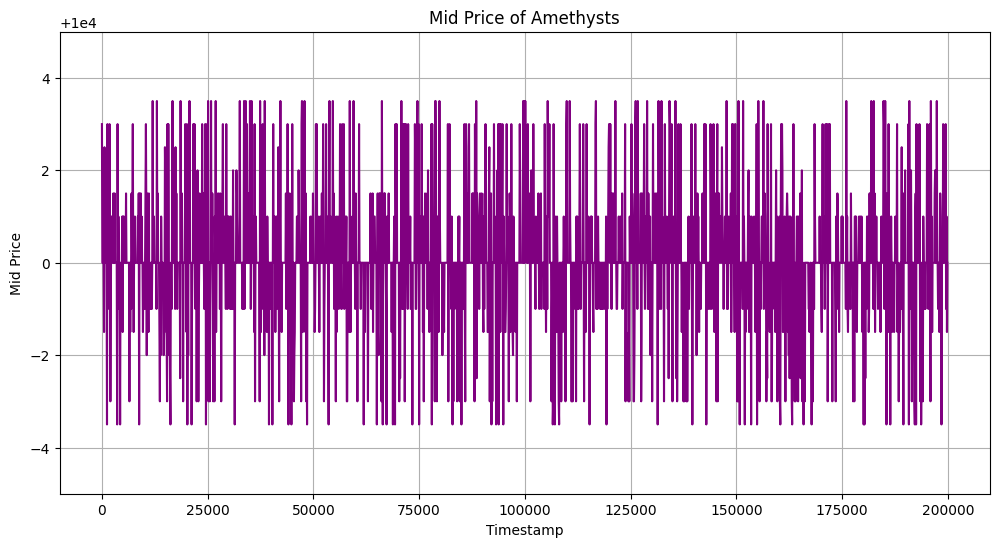

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(amethysts_data.index, amethysts_data['mid_price'], color='purple')
plt.title('Mid Price of Amethysts')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.ylim(9995, 10005)  # Setting the y-axis limits to start at 0 and end a bit above the max value
plt.grid(True)
plt.show()

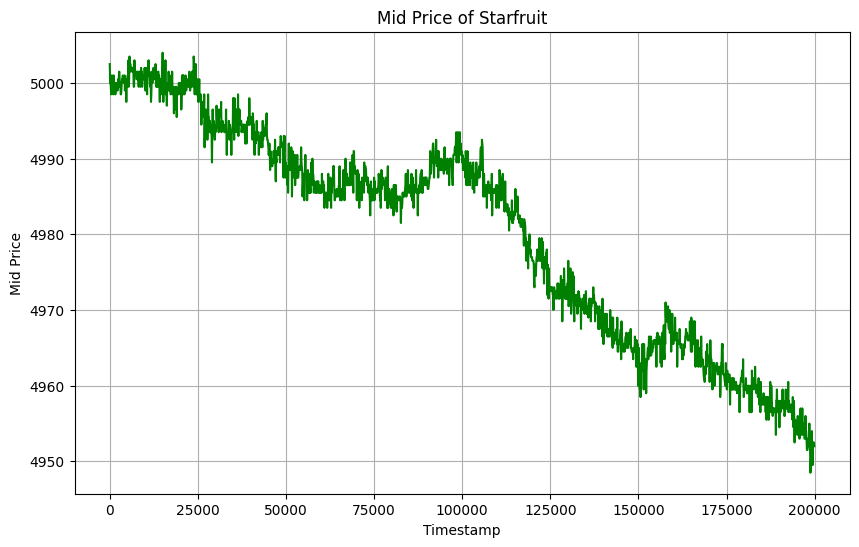

In [7]:
# Plot for Starfruit
plt.figure(figsize=(10, 6))
plt.plot(starfruit_data.index, starfruit_data['mid_price'], color='green')

plt.title('Mid Price of Starfruit')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.grid(True)
plt.show()

In [42]:
# Calculate the rolling mean of the 'mid_price'
starfruit_data['mid_price_sma'] = starfruit_data['mid_price'].rolling(window=5).mean()

# Compute the derivative (rate of change) of the 'mid_price'
starfruit_data['mid_price_derivative'] = starfruit_data['mid_price'].diff()

# Calculate the rolling mean of the derivative
starfruit_data['derivative_sma'] = starfruit_data['mid_price_derivative'].rolling(window=2).mean()

# Calculate the standard deviation of the derivative
starfruit_data['derivative_std'] = starfruit_data['mid_price_derivative'].rolling(window=2).std()

# Establish Bollinger Bands for the derivative
starfruit_data['upper_band'] = starfruit_data['derivative_sma'] + (starfruit_data['derivative_std'] * 0.2)
starfruit_data['lower_band'] = starfruit_data['derivative_sma'] - (starfruit_data['derivative_std'] * 0.2)

starfruit_data.to_csv('starfruit.csv')

In [43]:
daily_returns = []
trade_log = []
position_open = False
position_type = None

for timestamp, row in starfruit_data.iterrows():
    bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
    ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
    best_bid_price = min(bid_prices)
    best_bid_volume = row['bid_volume_' + str(bid_prices.index(best_bid_price) + 1)]
    best_ask_price = max(ask_prices)
    best_ask_volume = row['ask_volume_' + str(ask_prices.index(best_ask_price) + 1)]


    lower_band_value = row['lower_band']
    upper_band_value = row['upper_band']
    mean_value = row['derivative_sma']
    mid_price_derivative = row['mid_price_derivative']
    
    # Open position logic
    if mid_price_derivative < lower_band_value and not position_open:
        # Open short position at best ask
        shares = best_ask_volume
        trade_log.append({
            'Date': timestamp,
            'Action': 'Open Position',
            'Type': 'Short',
            'Shares': best_ask_volume,
            'Price': best_ask_price,
        })
        position_open = True
        position_type = 'Short'

    elif mid_price_derivative > upper_band_value and not position_open:
        # Open long position at best bid
        shares = best_bid_volume
        trade_log.append({
            'Date': timestamp,
            'Action': 'Open Position',
            'Type': 'Long',
            'Shares': best_bid_volume,
            'Price': best_bid_price,
        })
        position_open = True
        position_type = 'Long'
    
    elif mid_price_derivative > mean_value and position_open and position_type == 'Short':
        trade_log.append({
            'Date': timestamp,
            'Action': 'Close Position',
            'Type': 'Short',
            'Shares': shares,
            'Price': best_bid_price,
        })
        position_open = False
        
    elif mid_price_derivative < mean_value and position_open and position_type == 'Long':
        trade_log.append({
            'Date': timestamp,
            'Action': 'Close Position',
            'Type': 'Long',
            'Shares': shares,
            'Price': best_ask_price,
        })
        position_open = False

# Save the trade log to a DataFrame and then to a csv file
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

In [44]:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []

for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'Long':
            profit_loss = (trade['Price'] - open_position['Price']) * open_position['Shares']
        elif open_position['Type'] == 'Short':
            profit_loss = (open_position['Price'] - trade['Price']) * open_position['Shares']
        
        total_return += profit_loss
        close_position_returns.append(profit_loss)

        open_position = None

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

print(f"Total return from strategy: {total_return}")

Total return from strategy: 138968.0


In [45]:
profit_loss_df = pd.read_csv('returns.csv')

daily_returns = profit_loss_df['Profit/Loss'] / 5000

average_daily_return = daily_returns.mean()

annual_risk_free_rate = 0.02

daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1

excess_daily_returns = daily_returns - daily_risk_free_rate

std_dev_excess_daily_returns = excess_daily_returns.std()

sharpe_ratio = (excess_daily_returns.mean() / std_dev_excess_daily_returns) * (252 ** 0.5)

print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 97.46070243591001
